# Sample plotting routine for SFT 1D

Here is an example of the plotting the outputs from Surface Flux Transport model 1D. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
import matplotlib.style
#plt.ion()
## Plotting canvas properties.
params = {'legend.fontsize': 12,
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize' :10,
          'ytick.labelsize': 10,
          'grid.color': 'k',
          'grid.linestyle': ':',
          'grid.linewidth': 0.5,
          'mathtext.fontset' : 'stix',
          'mathtext.rm'      : 'DejaVu serif',
          'font.family'      : 'DejaVu serif',
          'font.serif'       : "Times New Roman", # or "Times"          
         }
matplotlib.rcParams.update(params)

from scipy.io import netcdf_file
import os
import pickle
import glob
import datetime
from datetime import datetime as dt1
from datetime import timedelta
import f90nml

Set the time range for the plot.

In [2]:
t_sft = np.arange(dt1(2010,6,17), dt1(2024,6,14), timedelta(days=1)).astype(dt1)

Function to convert time string to fractional year.

In [3]:
def frac_year(time_string):
	SECONDS_IN_DAY = 60.0*60.0*24.0
	SECONDS_IN_YEAR = SECONDS_IN_DAY*365.25
	t1 = datetime.datetime.strptime(time_string, '%Y-%m-%d') #stime.parse_time(time_string)
	t1_diff = t1 - datetime.datetime(t1.year,1,1,0,0,0)
	frac_year = (t1_diff.days + t1_diff.seconds/(60*60*24.0))/365.25
	return t1.year + frac_year

Create a plot dir to save the results.

In [4]:
PLOTPATH = os.getcwd()+'/plots'
if not os.path.exists(PLOTPATH):
    os.makedirs(PLOTPATH)

Read the parameter file to retrive the values

In [5]:
nml = f90nml.read('initial_Parameters.nml')
eta = nml['user']['eta']

Read the butterfly diagram file from the output directory.

30.7


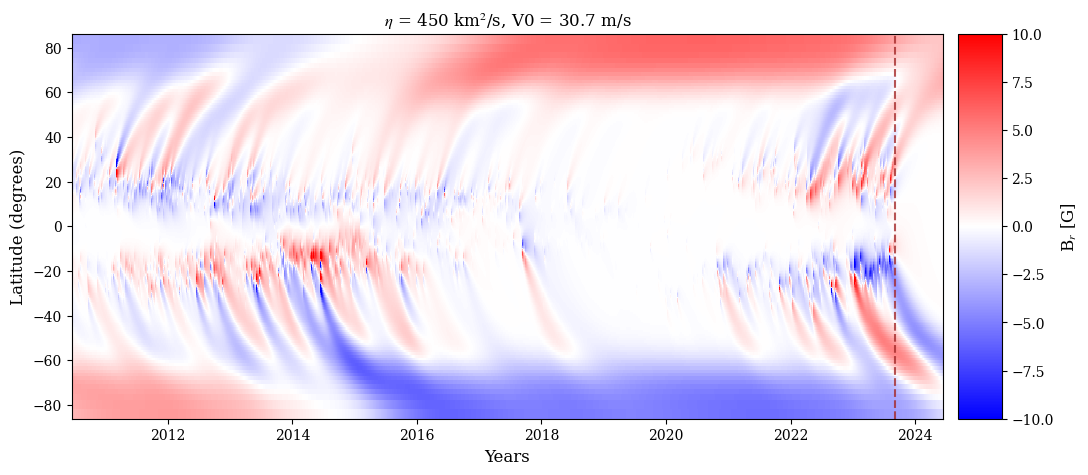

In [6]:
bfly1 = glob.glob(os.getcwd()+'/output_files/bfly_%3d_*.nc'%int(eta))[0]

fh2 = netcdf_file(bfly1)
bfly = fh2.variables['bfly'].data.copy()
sth = fh2.variables['sth'].data.copy()
time = fh2.variables['time'].data.copy()

fh2.close()

# Plot the butterfly diagram for the SFT simulation output
fig = plt.figure(figsize=[12,5])
ax1 = plt.subplot(111)

vel = glob.glob(os.getcwd()+'/output_files/MC_vel*.dat')[0]
v1 = np.loadtxt(vel)
L1 = 6.96e5
print('%2.1f'%(np.max(v1[:,1])*L1*1E3))
pm = ax1.pcolormesh(time,np.rad2deg(np.arcsin(sth)),bfly,cmap='bwr',vmax=10,vmin=-10)
ax1.set_xlim([time[0],time[-1]])  
# ax1.set_xlim([-90,90])
ax1.set_xlabel('Years')
ax1.set_ylabel('Latitude (degrees)')
ax1.axvline(x = frac_year('2023-09-04'), c='brown',ls='--',alpha=0.8)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(pm, cax=cax, orientation='vertical',label='B$_r$ [G]')
ax1.set_title('$\eta$ = %3d km$^2$/s, V0 = %2.1f m/s'%(int(eta),np.max(v1[:,1])*L1*1E3))

# plt.savefig(PLOTPATH+'/bfly_all_bipoles_450_155.png',
#             dpi=300,transparent=False,bbox_inches='tight')
plt.show()


Plot and compare the HMI polar field data with SFT simulation output. The HMI observations are written to a pickle file and distributed along with the model for easy access.

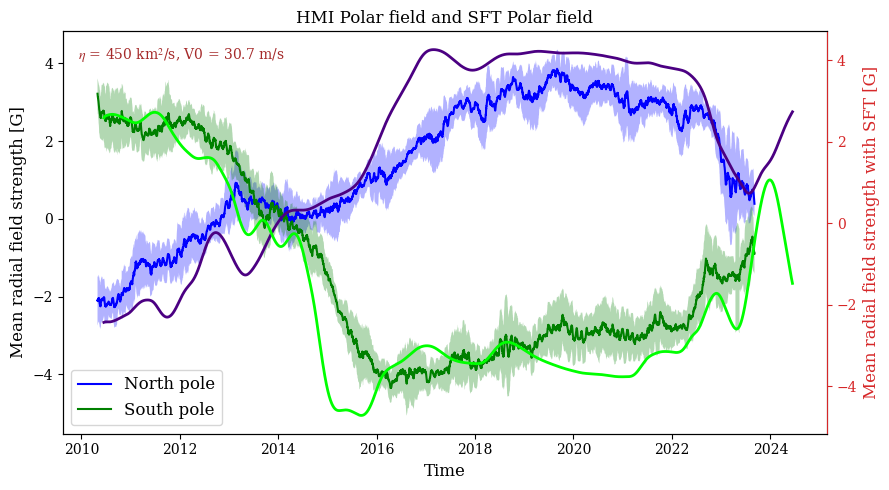

In [7]:
picklefile = open(os.getcwd()+'/hmi_polar_field.p','rb')
n = pickle.load(picklefile)
s = pickle.load(picklefile)
mn = pickle.load(picklefile)
ms = pickle.load(picklefile)
sn = pickle.load(picklefile)
ss = pickle.load(picklefile)
t = pickle.load(picklefile)
picklefile.close()


# Plot raw data
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.fill_between(t, mn - sn, mn + sn, edgecolor="none", facecolor="b", alpha=0.3, interpolate=True)
ax.fill_between(t, ms - ss, ms + ss, edgecolor="none", facecolor="g", alpha=0.3, interpolate=True)
ax.plot(t, mn, "b", label="North pole")
ax.plot(t, ms, "g", label="South pole")

ax2 = ax.twinx()
ind = np.where(np.rad2deg(np.arcsin(sth)) > 60)[0][0]

ax2.plot(t_sft,np.sum(bfly[ind:,:],axis=0)/np.shape(bfly[ind:,:])[0],lw=2,c='indigo',label='Northern hemisphere')
ax2.plot(t_sft,np.sum(bfly[0:181-ind,:],axis=0)/np.shape(bfly[0:181-ind,:])[0],lw=2,c='lime',label='Southern hemisphere')


ax2.set_ylabel("Mean radial field strength with SFT [G]", color="C3")
# ax3.set_xlabel("Time", color="C1")

ax2.tick_params(axis="y", color="C3", labelcolor="C3")
ax2.spines["right"].set_color("C3")

ax.set_title('HMI Polar field and SFT Polar field', fontsize="large")

ax.set_xlabel("Time")
ax.set_ylabel("Mean radial field strength [G]")
ax.legend(loc = 3)
fig.tight_layout()

ax.text(0.02,0.93,'$\eta$ = %3d km$^2$/s, V0 = %2.1f m/s'%(int(eta),np.max(v1[:,1])*L1*1E3)
        ,color='brown',fontsize=10,transform=ax.transAxes)

# plt.savefig(PLOTPATH+'/polar_field_comparision_%3d_%3d.png'%(int(eta),np.max(v1[:,1])*L1*1E4),
#             dpi=300,transparent=False,bbox_inches='tight')
plt.show()

Read and plot the dipole moment and velocity profile used in the simulation.

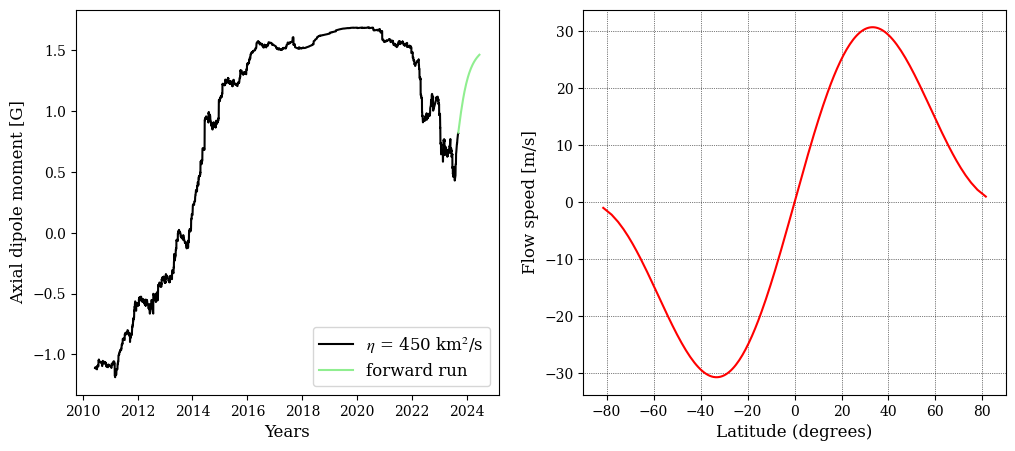

In [8]:
f1 = glob.glob(os.getcwd()+'/output_files/DM_*.dat')[0]
f2 = np.loadtxt(f1)


plt.figure(figsize=[12,5])
ax1 = plt.subplot(121)
ax1.plot(time[:np.where(time >= frac_year('2023-09-04'))[0][0]],f2[:np.where(time >= frac_year('2023-09-04'))[0][0],1],label='$\eta$ = %3d km$^2$/s'%(int(eta)),c='k')

ax1.plot(time[np.where(time >= frac_year('2023-09-04'))[0][0]:-1],f2[np.where(time >= frac_year('2023-09-04'))[0][0]:,1],label='forward run',c='lightgreen')

# ax1.set_xlim([time[0],frac_year('2023-09-04')])
ax1.set_xlabel('Years')
ax1.set_ylabel('Axial dipole moment [G]')
ax1.legend()

ax2 = plt.subplot(122)
vel = glob.glob(os.getcwd()+'/output_files/MC_vel*.dat')[0]
v1 = np.loadtxt(vel)
ax2.plot(np.rad2deg(np.arcsin(v1[:,0])),v1[:,1]*L1*1E3,label='20',c='r')

ax2.set_xlim([-90,90])
ax2.set_xlabel('Latitude (degrees)')
ax2.set_ylabel('Flow speed [m/s]')
ax2.grid()
# plt.savefig(PLOTPATH+'/DM_flows_%3d_%3d.png'%(int(eta),np.max(v1[:,1])*L1*1E4),
#             dpi=300,transparent=False,bbox_inches='tight')
plt.show()

